## Auto Encoders

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:15<00:00, 1.71MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 482kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.41MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.1MB/s]


In [6]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
        )        

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# early stoping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0


    def __call__(self, loss):

        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >=self.patience:
            return True
        return False

In [11]:
# model training
epochs = 5
learning_rate = 1e-3

model = AutoEncoder()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [13]:
def training(model, train_loader, loss_fn, optimizer, early_stopping, epochs):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, _ in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = loss_fn(output, inputs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.3f}")

        if early_stopping(avg_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

training(model=model, train_loader=train_loader, loss_fn=loss_fn, optimizer=optimizer, early_stopping=early_stopping, epochs=epochs)

Epoch: 1/5, Loss: 0.033
Epoch: 2/5, Loss: 0.017
Epoch: 3/5, Loss: 0.015
Epoch: 4/5, Loss: 0.013
Epoch: 5/5, Loss: 0.012


In [19]:
from scipy.ndimage import gaussian_filter

def compute_ssim(img1, img2, sigma=1.5):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    mu1 = gaussian_filter(input=img1, sigma=sigma)
    mu2 = gaussian_filter(input=img2, sigma=sigma)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = gaussian_filter(input=img1 ** 2, sigma=sigma) - mu1_sq
    sigma2_sq = gaussian_filter(input=img2 ** 2, sigma=sigma) - mu2_sq
    sigma12 = gaussian_filter(input=img1 * img2, sigma=sigma) - mu1_mu2

    numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)

    ssim_map = numerator / denominator
    return np.mean(ssim_map)

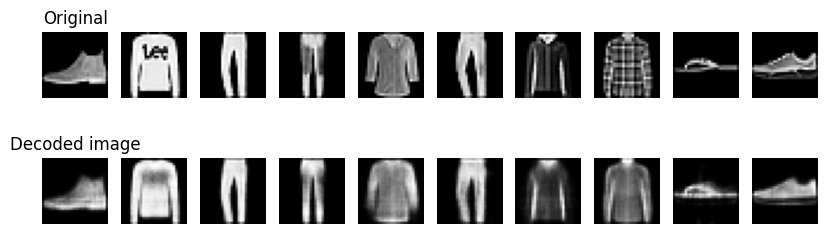

Average ssim: 0.9996997282783797


In [23]:
def evaluate(model, test_loader, n_images = 10):
    model.eval()

    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            break

    inputs = inputs.numpy()
    outputs = outputs.numpy()

    fig, axes = plt.subplots(2, n_images, figsize=(n_images, 3))
    ssim_scores = []

    for i in range(n_images):
        img1 = np.squeeze(inputs[i])
        img2 = np.squeeze(outputs[i])

        ssmi_score = compute_ssim(img1, img2)
        ssim_scores.append(ssmi_score)

        axes[0,i].imshow(img1, cmap="gray")
        axes[0,i].axis("off")
        axes[1,i].imshow(img2, cmap="gray")
        axes[1,i].axis("off")

    axes[0,0].set_title("Original")
    axes[1,0].set_title("Decoded image")

    plt.show()

    avg_ssim = np.mean(ssim_scores)
    print(f"Average ssim: {avg_ssim}")

evaluate(model=model, test_loader=test_loader, n_images=10)